In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 18 09:38:31 2023

@author: dalil.youcefi
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.base import clone
import joblib
import pickle
import patsy
import doubleml as dml

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

path="C:/Users/dalil.youcefi/Documents/Formation et retour à l'emploi/Données"
dates= pd.date_range('2017-01-01','2021-07-01' , freq='1M')-pd.offsets.MonthBegin(1)
dates=[date_obj.strftime('%Y-%m-%d') for date_obj in dates]

var_quel=["emploi_quelconque_t_plus_3","emploi_quelconque_t_plus_6",  "emploi_quelconque_t_plus_12" ,"emploi_quelconque_t_plus_18" ,"emploi_quelconque_t_plus_24","emploi_quelconque_t_plus_36"]


variables=["emploi_quelconque_t_plus_3","emploi_quelconque_t_plus_6",  "emploi_quelconque_t_plus_12" ,"emploi_quelconque_t_plus_18" ,"emploi_quelconque_t_plus_24","emploi_quelconque_t_plus_36",
            
            "emploi_durable_t_plus_3","emploi_durable_t_plus_6", "emploi_durable_t_plus_12" , "emploi_durable_t_plus_18" ,"emploi_durable_t_plus_24" ,"emploi_durable_t_plus_36"]


df_cf=pd.read_csv(path+"/Résultats/tab_toutes_form_cf.csv")

Recupérer le nombre de traiter

In [10]:
li_poids=[]
for cohorte in dates:
    df=pd.read_parquet(path+"/Prepro/Toutes Form/prepro_data_"+cohorte+".parquet",engine='pyarrow')
    li_poids.append(df.shape[0])


In [11]:
for var in var_quel:
    
    
    df_cf["upp_"+var]=df_cf["ate_"+var]+1.96*df_cf["std_"+var]
    df_cf["low_"+var]=df_cf["ate_"+var]-1.96*df_cf["std_"+var]
    
df_cf["poids"]=li_poids

In [12]:
li_poids=[1 for c in dates]

On récupère les résultats des DML PLR et IRM et de CF

In [13]:



dic_irm={}
dic_plr={}




dic_irm["cohorte"]=dates
dic_plr["cohorte"]=dates
dic_irm["poids"]=li_poids
dic_plr["poids"]=li_poids
df_cf["poids"]=li_poids

for var in var_quel:
    irm_coef=[]
    plr_coef=[]
    irm_upp=[]
    irm_low=[]
    plr_upp=[]
    plr_low=[]

    
        
    
    
    for cohorte in dates:
     
      
        
        dml_irm_obj=joblib.load( path+"/Résultats/Python/IRM/Toutes Form/dml_irm_"+cohorte+"_"+var+".joblib")
        irm_coef.append(dml_irm_obj.summary.coef)
        irm_low.append(dml_irm_obj.confint()["2.5 %"])
        irm_upp.append(dml_irm_obj.confint()["97.5 %"])
        
        
        
        dml_plr_obj=joblib.load( path+"/Résultats/Python/PLR/Toutes Form/dml_PLR_"+cohorte+"_"+var+".joblib")
        plr_coef.append(dml_plr_obj.summary.coef)
        plr_low.append(dml_plr_obj.confint()["2.5 %"])
        plr_upp.append(dml_plr_obj.confint()["97.5 %"])
   
    dic_irm["coef_"+var]=irm_coef
    dic_irm["upp_"+var]=irm_upp
    dic_irm["low_"+var]=irm_low
    
    
    dic_plr["coef_"+var]=plr_coef
    dic_plr["upp_"+var]=plr_upp
    dic_plr["low_"+var]=plr_low
    




   
df_irm=pd.DataFrame.from_dict(dic_irm,orient="columns")
df_plr=pd.DataFrame.from_dict(dic_plr,orient="columns")

  

var_float= list(df_plr.columns)
var_float.remove("cohorte")
  
df_irm[var_float]=df_irm[var_float].astype(float)
df_plr[var_float]=df_plr[var_float].astype(float)






On calcule la moyenne sur les cohortes aux différents horizons

In [14]:




dic_avg={}



irm_coef=[]
plr_coef=[]
irm_upp=[]
irm_low=[]
plr_upp=[]
plr_low=[]




def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    return (val * wt).sum() / wt.sum()
 


dic_avg={}


dic_avg["temps"]=["3","6","12","18","24","36"]

cf_coef=[]
cf_upp=[]
cf_low=[]



for var in var_quel:
    
    cf_coef.append(weighted_average(df_cf,"ate_"+var,"poids"))

    cf_upp.append(weighted_average(df_cf,"upp_"+var,"poids"))

    
    cf_low.append(weighted_average(df_cf,"low_"+var,"poids"))
  
    


dic_avg["cf_coef"]=cf_coef
dic_avg["cf_upp"]=cf_upp
dic_avg["cf_low"]=cf_low



    


for var in var_quel:
    
    irm_coef.append(weighted_average(df_irm,"coef_"+var,"poids"))
    plr_coef.append(weighted_average(df_plr,"coef_"+var,"poids"))
    
    irm_upp.append(weighted_average(df_irm,"upp_"+var,"poids"))
  
    
    irm_low.append(weighted_average(df_irm,"low_"+var,"poids"))
    
    plr_upp.append(weighted_average(df_plr,"upp_"+var,"poids"))
  
    
    plr_low.append(weighted_average(df_plr,"low_"+var,"poids"))
    

    
    


dic_avg["irm_coef"]=irm_coef
dic_avg["irm_upp"]=irm_upp
dic_avg["irm_low"]=irm_low




dic_avg["plr_coef"]=plr_coef
dic_avg["plr_upp"]=plr_upp
dic_avg["plr_low"]=plr_low
    

In [15]:
df_avg=pd.DataFrame.from_dict(dic_avg,orient="columns")

In [16]:
df_avg=df_avg*100

Table et graphique des moyennes

In [17]:
df_avg["temps"]=["3","6","12","18","24","36"]    

In [18]:
df_avg["cf_std"]=(df_avg["cf_coef"]-df_avg["cf_low"])/1.96
df_avg["plr_std"]=(df_avg["plr_coef"]-df_avg["plr_low"])/1.96
df_avg["irm_std"]=(df_avg["irm_coef"]-df_avg["irm_low"])/1.96


In [19]:
print(np.round(df_avg[["plr_coef","plr_std","irm_coef","irm_std","cf_coef","cf_std"]],2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  plr\_coef &  plr\_std &  irm\_coef &  irm\_std &  cf\_coef &  cf\_std \\
\midrule
0 &     -0.17 &     0.29 &     -0.07 &     0.27 &    -0.20 &    0.38 \\
1 &      4.51 &     0.36 &      4.65 &     0.34 &     4.40 &    0.48 \\
2 &      9.93 &     0.41 &     10.18 &     0.38 &     9.78 &    0.54 \\
3 &     12.64 &     0.42 &     12.94 &     0.39 &    12.34 &    0.55 \\
4 &     13.35 &     0.41 &     13.70 &     0.38 &    12.96 &    0.54 \\
5 &     13.45 &     0.41 &     13.85 &     0.38 &    13.01 &    0.53 \\
\bottomrule
\end{tabular}



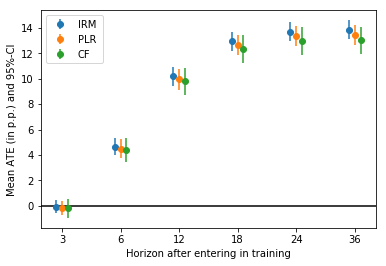

In [21]:



from matplotlib.transforms import Affine2D
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = 10., 7.5

trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0., 0.0) + ax.transData
trans3 = Affine2D().translate(+0.1, 0.0) + ax.transData

errors = np.full((2, df_avg.shape[0]), np.nan)
errors[0, :] = df_avg["irm_coef"] - df_avg["irm_low"]
errors[1, :] =  df_avg["irm_upp"]- df_avg["irm_coef"]

plt.errorbar(df_avg["temps"],df_avg["irm_coef"], fmt='o', yerr=errors, label='IRM ',transform=trans1)



errors = np.full((2, df_avg.shape[0]), np.nan)
errors[0, :] = df_avg["plr_coef"] - df_avg["plr_low"]
errors[1, :] =  df_avg["plr_upp"]- df_avg["plr_coef"]

plt.errorbar(df_avg["temps"],df_avg["plr_coef"], fmt='o', yerr=errors, label='PLR ',transform=trans2)


errors = np.full((2, df_avg.shape[0]), np.nan)
errors[0, :] = df_avg["cf_coef"] - df_avg["cf_low"]
errors[1, :] =  df_avg["cf_upp"]- df_avg["cf_coef"]

plt.errorbar(df_avg["temps"],df_avg["cf_coef"], fmt='o', yerr=errors, label='CF',transform=trans3)

plt.axhline(y = 0., color = 'black', linestyle = '-')



plt.xlabel('Horizon after entering in training')
plt.legend()
plt.ylabel('Mean ATE (in p.p.) and 95%-CI')

plt.savefig(path+"/ate_all_plot.png")


BLP pour la cohorte de Septembre 2017 a l'horizon t+18

In [23]:
dml_irm_obj=joblib.load( path+"/Résultats/Python/IRM/Toutes Form/dml_irm_"+"2017-09-01"+"_"+"emploi_quelconque_t_plus_18"+".joblib")

In [24]:
df=pd.read_parquet(path+"/Prepro/Toutes Form/prepro_data_"+"2017-09-01"+".parquet",engine='pyarrow')

In [25]:



design_matrix=patsy.dmatrix("~age+anciennete+sexe+zone_urbaine+handicap",data=df)



spline_basis = pd.DataFrame(design_matrix)

In [26]:
cate = dml_irm_obj.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0 -0.169293  0.008860 -19.108200   2.807366e-81 -0.186657 -0.151928
1  0.006728  0.000236  28.545940  1.161677e-178  0.006266  0.007190
2  0.000023  0.000004   6.394858   1.612521e-10  0.000016  0.000030
3 -0.040092  0.005305  -7.557142   4.147656e-14 -0.050490 -0.029694
4  0.020843  0.008444   2.468415   1.357259e-02  0.004293  0.037394
5 -0.032960  0.009748  -3.381055   7.222994e-04 -0.052066 -0.013853
